🔗 Mounting Google Drive...
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
Data split: 82,065 train records, 4,327 validation records.


/tmp/ipython-input-2402238412.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["neighborhood_log_mean"].fillna(global_mean, inplace=True)
/tmp/ipython-input-2402238412.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

✅ Data ready: X_train (82065, 196), X_val (4327, 196)


Training RF (blue progress):   0%|                                           | 0/10 [00:00<?, ?it/s]


⏹️ Early stopping triggered at 300 trees.

✅ Best Validation MAPE: 167.23%

📦 Saved toronto_rf_model_predictions.parquet to:
/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/toronto_rf_model_predictions.parquet
📊 Saved toronto_rf_feature_importances.csv to:
/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/toronto_rf_feature_importances.csv


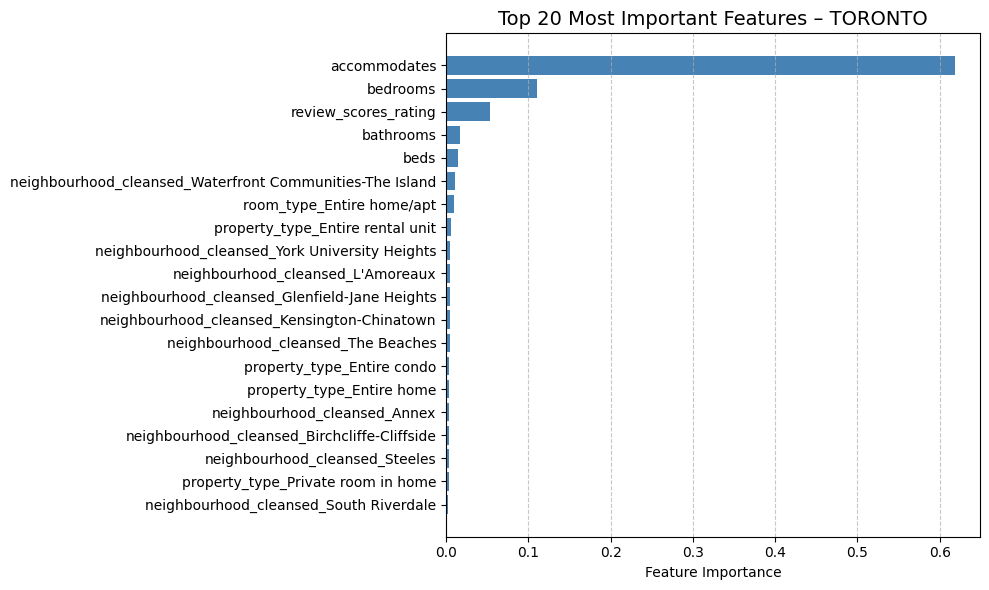


✅ All done! Toronto Random Forest baseline successfully trained.


In [1]:
# ===============================================================
#  Random Forest Baseline for Toronto
# ===============================================================

# --- Mount Google Drive ---
from google.colab import drive
print("🔗 Mounting Google Drive...")
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

# --- Imports ---
import os
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- Import the shared data split function ---
from data_processing import load_and_split_data

# ===============================================================
# 1️⃣ Configuration
# ===============================================================
config = {
    "CITY": "toronto",
    "SEED": 42,
    "VAL_SIZE": 0.05,
    "DRIVE_SAVE_PATH": "/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project"
}

# ===============================================================
# 2️⃣ Load Train/Validation Data (Same Split as NN)
# ===============================================================
train_df, val_df, neighborhood_log_means, train_ids_set, val_ids_set = load_and_split_data(config)

# Add split labels
train_df["split"] = "train"
val_df["split"] = "val"
full_df = pd.concat([train_df, val_df], ignore_index=True)

# ===============================================================
# 3️⃣ Feature Engineering for Random Forest
# ===============================================================
CAT_COLS = ["property_type", "room_type", "neighbourhood_cleansed"]
NUM_COLS = ["accommodates", "bedrooms", "bathrooms", "beds", "review_scores_rating"]
TARGET = "target_log_deviation"

# Target: log deviation from neighborhood mean
for df in [train_df, val_df, full_df]:
    df["neighborhood_log_mean"] = df["neighbourhood_cleansed"].map(neighborhood_log_means)
    global_mean = np.mean(list(neighborhood_log_means.values()))
    df["neighborhood_log_mean"].fillna(global_mean, inplace=True)
    df[TARGET] = np.log1p(df["price"]) - df["neighborhood_log_mean"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CAT_COLS),
        ("numeric", StandardScaler(), NUM_COLS)
    ]
)

# Fit transformer
X_train = preprocessor.fit_transform(train_df)
X_val = preprocessor.transform(val_df)
y_train = train_df[TARGET].values
y_val = val_df[TARGET].values

feature_names = (
    list(preprocessor.named_transformers_["categorical"].get_feature_names_out(CAT_COLS))
    + NUM_COLS
)

print(f"✅ Data ready: X_train {X_train.shape}, X_val {X_val.shape}")

# ===============================================================
# 4️⃣ Train Random Forest with Early Stopping on Val MAPE
# ===============================================================
best_model, best_mape, patience, max_patience = None, np.inf, 0, 5

rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=25,
    random_state=config["SEED"],
    n_jobs=-1,
    warm_start=True
)

progress = tqdm(range(50, 501, 50), desc="Training RF (blue progress)", colour="blue", ncols=100)

for n in progress:
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    y_pred_val = rf.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    val_mape = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred_val)) * 100

    progress.set_postfix({"Val MAPE (%)": f"{val_mape:.2f}", "RMSE": f"{val_rmse:.3f}"})

    if val_mape < best_mape:
        best_mape = val_mape
        best_model = rf
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print(f"\n⏹️ Early stopping triggered at {n} trees.")
            break

print(f"\n✅ Best Validation MAPE: {best_mape:.2f}%")

# ===============================================================
# 5️⃣ Generate Predictions for Full Dataset
# ===============================================================
X_full = preprocessor.transform(full_df)
full_df["predicted_log_dev"] = best_model.predict(X_full)
full_df["predicted_price"] = np.expm1(full_df["neighborhood_log_mean"] + full_df["predicted_log_dev"])

# ===============================================================
# 6️⃣ Artifact 1: Save Predictions DataFrame
# ===============================================================
required_cols = [
    "id", "name", "latitude", "longitude", "neighbourhood_cleansed",
    "month", "split", "price", "predicted_price"
]

predictions_df = full_df[required_cols].copy()
os.makedirs(config["DRIVE_SAVE_PATH"], exist_ok=True)
pred_path = os.path.join(config["DRIVE_SAVE_PATH"], f"{config['CITY']}_rf_model_predictions.parquet")
predictions_df.to_parquet(pred_path, index=False)

print(f"\n📦 Saved {config['CITY']}_rf_model_predictions.parquet to:\n{pred_path}")

# ===============================================================
# 7️⃣ Artifact 2: Feature Importances
# ===============================================================
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

imp_path = os.path.join(config["DRIVE_SAVE_PATH"], f"{config['CITY']}_rf_feature_importances.csv")
importance_df.to_csv(imp_path, index=False)
print(f"📊 Saved {config['CITY']}_rf_feature_importances.csv to:\n{imp_path}")

# ===============================================================
# 8️⃣ Visualize Feature Importances
# ===============================================================
top_feats = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_feats["feature"], top_feats["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.title(f"Top 20 Most Important Features – {config['CITY'].upper()}", fontsize=14)
plt.xlabel("Feature Importance")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("\n✅ All done! Toronto Random Forest baseline successfully trained.")